In [1]:
from honeybee.model import Model
from honeybee_radiance.sensorgrid import SensorGrid
import matplotlib as mpl
from matplotlib.pyplot import pcolormesh
from ladybug_geometry.geometry3d import Point3D
import numpy as np
import os

import matplotlib.pyplot as plt
from matplotlib.path import Path
from matplotlib.patches import PathPatch
from matplotlib.collections import PatchCollection

In [2]:
def file_to_array(result_file_path):
    """Takes a .res filepatch and returns a np.array of the data within"""
    f = open(result_file_path, "r")
    res = f.read()
    # each result is on a new line
    res = res.split('\n')

    # try catch to avoid error from the final new line that has no data on
    nums = []
    for i in res:
        try:
            nums.append(float(i))
        except: 
            pass
    # list of floats to np.array
    num_array = np.array(nums)
    return num_array

def mask_filter(filter_str, grid_list):
    """functions like grid filter in HB, looks for string in grid.identifier, returns True/False list if string is found"""
    names = []
    for grid in grid_list:
        names.append(grid.identifier)
    
    mask = []
    for name in names:
        mask.append(filter_str in name)

    return mask

def get_files_of_type(extension, directory):
    """finds files with specified extension, e.g. 'txt' in a folder. Does not check sub folders"""
    files = []
    for file in os.listdir(directory):
        if file.endswith("."+extension):
            files.append(os.path.join(directory, file))
    return files

def get_model(folder):
    # Should only be one hbjson file in the folder generated by the recipe
    hbjson_file = get_files_of_type('hbjson', folder)[0]
    model = Model.from_hbjson(hbjson_file)
    return model

def data_for_vis(folder, model, filter_str = None):
    """folder to DF recipe folder as generated by HB, TODO expand to other recipes with work"""
    # Get all grids assigned to the model
    grids = model.properties.radiance.sensor_grids
    names = []
    # Get names of grids and filepaths of results files for each grid
    result_files = []
    for grid in grids:
        name = grid.identifier
        names.append(name)
        result_files.append(folder+"\\results\\"+name+".res")
    # Create np.array for each result file. Could be made more efficient by doing this after mask filter
    results = []
    for file in result_files:
        res = file_to_array(file)
        results.append(res)
    # if filter_str given then filter outputs for only those containing str
    if filter_str is not None:
        mask = mask_filter(filter_str, grids)
        names = [b for a,b in zip(mask, names) if a]
        grids = [b for a,b in zip(mask, grids) if a]
        results = [b for a,b in zip(mask, results) if a]
    else:
        pass
    return names, grids, results

def datatree_grids_patches_from_grids(grids):
    """Takes a list of grids and returns a list of lists, of patches (mesh faces) per grid"""
    grids_faces_vertices = []
    for grid in grids:
        mesh = grid.mesh
        datatree_faces_vertices = mesh.face_vertices
        faces = []
        for face in datatree_faces_vertices:
            face_vertices = []
            for vertice in face:
                x , y = vertice.x, vertice.y
                face_vertices.append([x,y])
            face_vertices.append(face_vertices[0])
            faces.append(face_vertices) 
        grids_faces_vertices.append(faces) 

    patches_per_grid = []
    for grid in grids_faces_vertices:
        patches = []
        for face in grid:
            path = Path(face)
            patch = PathPatch(path, rasterized = True)
            patches.append(patch)
        patches_per_grid.append(patches)
    return patches_per_grid

def flatten(l):
    return [item for sublist in l for item in sublist]

In [3]:
# Separating out the slowest process
my_dir = r"C:\Users\cbrooker\Desktop\Tetley\AllInOne\Balconies\daylight_factor"
model = get_model(my_dir)

In [4]:
# Running everything needed to create the graphic, including grid filtering

data = data_for_vis(my_dir, model, filter_str = "_2_")

names = data[0]
grids = data[1]
results = data[2]

flat_results = np.concatenate(results, axis=0)

patches_per_grid = datatree_grids_patches_from_grids(grids)

patches = flatten(patches_per_grid)

c:\ProgramData\BHoM\Extensions\PythonEnvironments\LadybugTools_Toolkit\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  app.launch_new_instance()


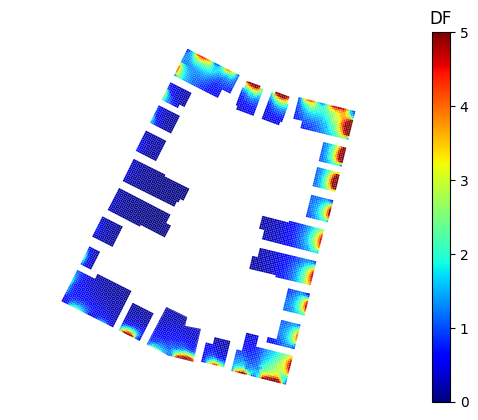

In [5]:
# Produce graphic
p = PatchCollection(patches, cmap=mpl.cm.jet, alpha=1)
p.set_array(flat_results)

fig, ax = plt.subplots()

ax.add_collection(p)
# autoscale to contents
ax.autoscale(True)
# fix aspect ratio
ax.axis('equal')
# turn off axes
ax.axis('off')
# Legend 
fig.colorbar(p).ax.set_title('DF')
p.set_clim([0,5])
fig.show()
plt.savefig("test.svg", bbox_inches='tight', dpi=500)
plt.savefig("test.png", bbox_inches='tight', dpi=500)


In [6]:
# All results

data = data_for_vis(my_dir, model)

In [9]:
import pandas as pd

In [10]:
pd.DataFrame([data[0],data[1]])

,0,1,2,3,4,5,6,7,8,9,...,287,288,289,290,291,292,293,294,295,296
0,Bedrooms_0_1,Living_0_1,Kitchen_0_1,Bedrooms_0_2,Living_0_2,Kitchen_1_2,Bedrooms_0_3,Living_0_3,Kitchen_2_3,Bedrooms_0_4,...,Bedrooms_12_171,Bedrooms_12_172,Bedrooms_12_173,Bedrooms_12_174,Bedrooms_12_175,Bedrooms_12_176,Bedrooms_12_177,Bedrooms_12_178,Bedrooms_12_179,Bedrooms_12_180
1,(-6.297278852614408 -93.81603152829769 4.14 0....,(-10.291801740712575 -80.09522799194022 4.14 0...,(-10.973831282124545 -91.57972960526492 4.1399...,(6.658781142334883 -81.82998160854818 4.14 0.0...,(-16.302120474418555 -78.30082799044017 4.14 0...,(-10.912822246551514 -91.76275634765625 8.3139...,(7.4982777393951 -78.45650445123931 4.14 0.0 0...,(-19.687376062263198 -84.4777684579215 4.14 0....,(-10.912822246551514 -91.76275634765625 11.613...,(8.182466976568685 -75.69232252958058 4.14 0.0...,...,(-10.586362910683214 -72.18201446839838 44.613...,(-11.209466296395385 -73.18714102145925 44.613...,(-17.059138988303904 -84.71627405517317 44.613...,(-14.742366303337798 -91.1710539949091 44.6139...,(8.243476585890544 -75.8753513578473 44.613977...,(7.559287348716962 -78.63953327950603 44.61397...,(6.719790751656745 -82.0130104368149 44.613977...,(3.028889653277762 -96.05364593196119 44.61397...,(-20.426539218089037 -86.7367770078032 44.6139...,(-4.769378745640792 -98.06344560329791 44.6139...


In [21]:
# Credit to Alleo - https://stackoverflow.com/questions/21844024/weighted-percentile-using-numpy
def weighted_quantile(values, quantiles, sample_weight=None, 
                      values_sorted=False, old_style=False):
    """ Very close to numpy.percentile, but supports weights.
    NOTE: quantiles should be in [0, 1]!
    :param values: numpy.array with data
    :param quantiles: array-like with many quantiles needed
    :param sample_weight: array-like of the same length as `array`
    :param values_sorted: bool, if True, then will avoid sorting of
        initial array
    :param old_style: if True, will correct output to be consistent
        with numpy.percentile.
    :return: numpy.array with computed quantiles.
    """
    values = np.array(values)
    quantiles = np.array(quantiles)
    if sample_weight is None:
        sample_weight = np.ones(len(values))
    sample_weight = np.array(sample_weight)
    assert np.all(quantiles >= 0) and np.all(quantiles <= 1), \
        'quantiles should be in [0, 1]'

    if not values_sorted:
        sorter = np.argsort(values)
        values = values[sorter]
        sample_weight = sample_weight[sorter]

    weighted_quantiles = np.cumsum(sample_weight) - 0.5 * sample_weight
    if old_style:
        # To be convenient with numpy.percentile
        weighted_quantiles -= weighted_quantiles[0]
        weighted_quantiles /= weighted_quantiles[-1]
    else:
        weighted_quantiles /= np.sum(sample_weight)
    return np.interp(quantiles, weighted_quantiles, values)

In [46]:
face_areas = []

for grid in grids:
    face_areas.append(np.array(grid.mesh.face_areas))

for_weighting = zip(results, face_areas)

median_results = []
for array in for_weighting:
    median_results.append(*list(weighted_quantile(values= array[0],quantiles=[0.5],sample_weight = array[1])))

median_results

[0.5385540035412811,
 1.346190030098031,
 2.020355931325694,
 0.669316545388922,
 0.6692967497071407,
 0.042671173173281875,
 0.04771904698501589,
 1.677202128021818,
 0.390990956140181,
 1.464225196202893,
 1.0426215844978175,
 1.0051765586170736,
 0.40741207937211615,
 0.2514237534928634,
 0.18926315354820164,
 0.17365889966486042,
 0.32197282233576624,
 2.1599786895795727,
 2.3972817460430518,
 1.5163296685659082,
 1.3133627515916857,
 0.3857053355999919,
 0.5248727223677637]

In [40]:
for_weighting = zip(results, face_areas)

mean_results = []
for array in for_weighting:
    mean_results.append(np.average(a = array[0],weights = array[1]))

mean_results

[0.8937362013889413,
 1.5560417772668116,
 2.414904901292208,
 1.0272524502658011,
 0.9970434370402177,
 0.07033757230495782,
 0.08148805698878625,
 1.9890416182880901,
 0.4940505577817845,
 1.7861510517553345,
 1.641390094950183,
 1.6115230256618431,
 0.6313416166729751,
 0.37843142216184883,
 0.2265572606699151,
 0.2224168541014221,
 0.8440294062488894,
 2.9062767481094043,
 2.956342232204779,
 1.8631951501354764,
 1.5449395875009735,
 0.5988331070999494,
 0.8489946746832976]

In [47]:
names

['Kitchen_2_3',
 'Living_2_10',
 'Living_2_11',
 'Living_2_12',
 'Living_2_13',
 'Living_2_14',
 'Living_2_15',
 'Living_2_16',
 'Living_2_17',
 'Bedrooms_2_27',
 'Bedrooms_2_28',
 'Bedrooms_2_29',
 'Bedrooms_2_30',
 'Bedrooms_2_31',
 'Bedrooms_2_32',
 'Bedrooms_2_33',
 'Bedrooms_2_34',
 'Bedrooms_2_35',
 'Bedrooms_2_36',
 'Bedrooms_2_37',
 'Bedrooms_2_38',
 'Bedrooms_2_39',
 'Bedrooms_2_40']

In [71]:
df = pd.DataFrame(list(zip(names, median_results, mean_results)), columns=['Grid_Name', 'Median_DF', 'Mean_DF'])
df.loc[df['Grid_Name'].str.contains('Living'), 'Room_Type'] = 'Living'
df.loc[df['Grid_Name'].str.contains('Bedroom'), 'Room_Type'] = 'Bedroom'
df.loc[df['Grid_Name'].str.contains('Kitchen'), 'Room_Type'] = 'Kitchen'

,Grid_Name,Median_DF,Mean_DF,Room_Type
0,Kitchen_2_3,0.538554,0.893736,Kitchen
1,Living_2_10,1.346190,1.556042,Living
2,Living_2_11,2.020356,2.414905,Living
3,Living_2_12,0.669317,1.027252,Living
4,Living_2_13,0.669297,0.997043,Living
5,Living_2_14,0.042671,0.070338,Living
6,Living_2_15,0.047719,0.081488,Living
7,Living_2_16,1.677202,1.989042,Living
8,Living_2_17,0.390991,0.494051,Living
9,Bedrooms_2_27,1.464225,1.786151,Bedroom


In [72]:
bed_med_DF = 0.7
living_med_DF = 1.1
kitchen_med_DF = 1.4

conditions = [
    (df['Room_Type'] == 'Bedroom') & (df['Median_DF'] >= bed_med_DF),
    (df['Room_Type'] == 'Living') & (df['Median_DF'] >= living_med_DF),
    (df['Room_Type'] == 'Kitchen') & (df['Median_DF'] >= kitchen_med_DF)]
choices = ['Pass', 'Pass', 'Pass']
df['BRE 209 Pass/Fail'] = np.select(conditions, choices, default='Fail')
print(df)

        Grid_Name  Median_DF   Mean_DF Room_Type BRE 209 Pass/Fail
0     Kitchen_2_3   0.538554  0.893736   Kitchen              Fail
1     Living_2_10   1.346190  1.556042    Living              Pass
2     Living_2_11   2.020356  2.414905    Living              Pass
3     Living_2_12   0.669317  1.027252    Living              Fail
4     Living_2_13   0.669297  0.997043    Living              Fail
5     Living_2_14   0.042671  0.070338    Living              Fail
6     Living_2_15   0.047719  0.081488    Living              Fail
7     Living_2_16   1.677202  1.989042    Living              Pass
8     Living_2_17   0.390991  0.494051    Living              Fail
9   Bedrooms_2_27   1.464225  1.786151   Bedroom              Pass
10  Bedrooms_2_28   1.042622  1.641390   Bedroom              Pass
11  Bedrooms_2_29   1.005177  1.611523   Bedroom              Pass
12  Bedrooms_2_30   0.407412  0.631342   Bedroom              Fail
13  Bedrooms_2_31   0.251424  0.378431   Bedroom              

In [66]:
conditions = [
    ('Bedroom' in df['Grid_Name']),
    ('Living' in df['Grid_Name']),
    ('Kitchen' in df['Grid_Name'])]
choices = ['Bedroom', 'Living', 'Kitchen']
df['Room Type'] = np.select(conditions, choices, default='Error')
print(df)

        Grid_Name  Median_DF   Mean_DF BRE 209 Pass/Fail Room Type
0     Kitchen_2_3   0.538554  0.893736              Fail     Error
1     Living_2_10   1.346190  1.556042              Fail     Error
2     Living_2_11   2.020356  2.414905              Fail     Error
3     Living_2_12   0.669317  1.027252              Fail     Error
4     Living_2_13   0.669297  0.997043              Fail     Error
5     Living_2_14   0.042671  0.070338              Fail     Error
6     Living_2_15   0.047719  0.081488              Fail     Error
7     Living_2_16   1.677202  1.989042              Fail     Error
8     Living_2_17   0.390991  0.494051              Fail     Error
9   Bedrooms_2_27   1.464225  1.786151              Fail     Error
10  Bedrooms_2_28   1.042622  1.641390              Fail     Error
11  Bedrooms_2_29   1.005177  1.611523              Fail     Error
12  Bedrooms_2_30   0.407412  0.631342              Fail     Error
13  Bedrooms_2_31   0.251424  0.378431              Fail     E

In [67]:
df

,Grid_Name,Median_DF,Mean_DF,BRE 209 Pass/Fail,Room Type
0,Kitchen_2_3,0.538554,0.893736,Fail,Error
1,Living_2_10,1.346190,1.556042,Fail,Error
2,Living_2_11,2.020356,2.414905,Fail,Error
3,Living_2_12,0.669317,1.027252,Fail,Error
4,Living_2_13,0.669297,0.997043,Fail,Error
5,Living_2_14,0.042671,0.070338,Fail,Error
6,Living_2_15,0.047719,0.081488,Fail,Error
7,Living_2_16,1.677202,1.989042,Fail,Error
8,Living_2_17,0.390991,0.494051,Fail,Error
9,Bedrooms_2_27,1.464225,1.786151,Fail,Error


In [68]:
df.loc[df['Grid_Name'].str.contains('Bedroom'), 'Room_Type'] = 'Bedroom'

In [69]:
df

,Grid_Name,Median_DF,Mean_DF,BRE 209 Pass/Fail,Room Type,Room_Type
0,Kitchen_2_3,0.538554,0.893736,Fail,Error,NaN
1,Living_2_10,1.346190,1.556042,Fail,Error,NaN
2,Living_2_11,2.020356,2.414905,Fail,Error,NaN
3,Living_2_12,0.669317,1.027252,Fail,Error,NaN
4,Living_2_13,0.669297,0.997043,Fail,Error,NaN
5,Living_2_14,0.042671,0.070338,Fail,Error,NaN
6,Living_2_15,0.047719,0.081488,Fail,Error,NaN
7,Living_2_16,1.677202,1.989042,Fail,Error,NaN
8,Living_2_17,0.390991,0.494051,Fail,Error,NaN
9,Bedrooms_2_27,1.464225,1.786151,Fail,Error,Bedroom
